In [185]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [186]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [187]:
query = """select *
        from eigensonne_dwh.public.lead_scoring_sample """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,outbound_calls,inbound_calls,has_been_wfp,time_in_queue
0,00Q5J000003ZoItUAK,Wattfox,affiliate,Hessen,67.0,Regular,1,0,0,1,0,0,0
1,00Q5J000003ZnhxUAC,KP,affiliate,Hessen,11.0,Regular,0,0,0,5,0,0,1
2,00Q5J000002rmI0UAI,Hausfrage,affiliate,Baden-Württemberg,144.0,Regular,1,1,1,1,0,1,0
3,00Q5J000003aQ0pUAE,Wattfox,affiliate,Baden-Württemberg,46.0,Regular,1,0,1,1,0,1,0
4,00Q5J000003ZhnUUAS,Website,cpc,Bayern,46.0,Regular,1,0,1,1,0,1,3


In [188]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [189]:
print(base.shape)
base.dtypes

(19171, 13)


id                            object
lead_source                   object
lead_medium                   object
bundesland                    object
distance                     float64
record_type_name_c            object
has_opened                     int64
has_clicked_non_photo_url      int64
photo_uploaded                 int64
outbound_calls                 int64
inbound_calls                  int64
has_been_wfp                   int64
time_in_queue                  int64
dtype: object

In [190]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19171 entries, 0 to 19170
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         19171 non-null  object 
 1   lead_source                19169 non-null  object 
 2   lead_medium                18246 non-null  object 
 3   bundesland                 19092 non-null  object 
 4   distance                   19092 non-null  float64
 5   record_type_name_c         19171 non-null  object 
 6   has_opened                 19171 non-null  int64  
 7   has_clicked_non_photo_url  19171 non-null  int64  
 8   photo_uploaded             19171 non-null  int64  
 9   outbound_calls             19171 non-null  int64  
 10  inbound_calls              19171 non-null  int64  
 11  has_been_wfp               19171 non-null  int64  
 12  time_in_queue              19171 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usag

In [191]:
base.describe()

,distance,has_opened,has_clicked_non_photo_url,photo_uploaded,outbound_calls,inbound_calls,has_been_wfp,time_in_queue
count,19092.000000,19171.000000,19171.000000,19171.000000,19171.000000,19171.000000,19171.000000,19171.000000
mean,43.279332,0.710135,0.101560,0.174482,2.144124,0.177143,0.350477,4.141568
std,29.013537,0.453711,0.302076,0.379534,2.013553,0.494857,0.477132,8.343942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,37.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000
75%,60.000000,1.000000,0.000000,0.000000,3.000000,0.000000,1.000000,3.000000
max,279.000000,1.000000,1.000000,1.000000,21.000000,8.000000,1.000000,96.000000


In [192]:
base.isnull().sum()

id                             0
lead_source                    2
lead_medium                  925
bundesland                    79
distance                      79
record_type_name_c             0
has_opened                     0
has_clicked_non_photo_url      0
photo_uploaded                 0
outbound_calls                 0
inbound_calls                  0
has_been_wfp                   0
time_in_queue                  0
dtype: int64

In [193]:
#see percentage of null values to drop the once >= 70%

round(100*(base.isnull().sum()/len(base.index)), 2)

id                           0.00
lead_source                  0.01
lead_medium                  4.82
bundesland                   0.41
distance                     0.41
record_type_name_c           0.00
has_opened                   0.00
has_clicked_non_photo_url    0.00
photo_uploaded               0.00
outbound_calls               0.00
inbound_calls                0.00
has_been_wfp                 0.00
time_in_queue                0.00
dtype: float64

In [194]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

In [195]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       19169
unique         11
top       Wattfox
freq         6328
Name: lead_source, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

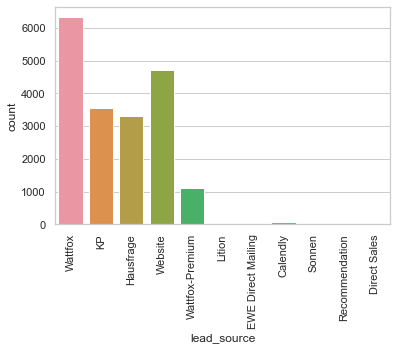

In [196]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [197]:
data.groupby(['lead_source'])['id'].count()

lead_source
Calendly                67
Direct Sales             4
EWE Direct Mailing       3
Hausfrage             3323
KP                    3539
Lition                  36
Recommendation          18
Sonnen                  22
Wattfox               6328
Wattfox-Premium       1119
Website               4710
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

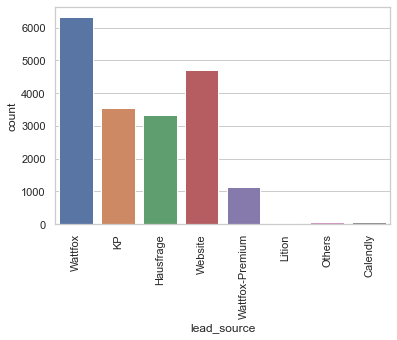

In [198]:
#taking into account that we always knows when leads come from affiliates, we will call the null values and 
#every lead comming from a source with a total of leads < 30 'Other'
data['lead_source'] = data['lead_source'].replace(np.nan, 'Others')
data['lead_source'] = data['lead_source'].replace(data.loc[data.groupby('lead_source').lead_source.transform('count').lt(30),
                               'lead_source'],'Others')

sns.countplot(data['lead_source'])
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

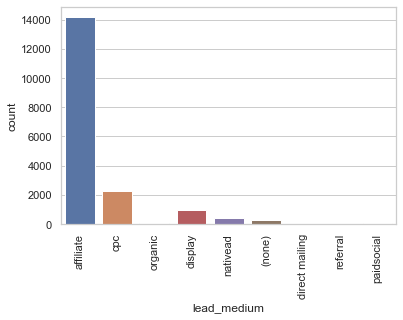

In [199]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [200]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)              247
affiliate         14179
cpc                2261
direct mailing        3
display             974
nativead            409
organic              97
paidsocial           40
referral             36
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

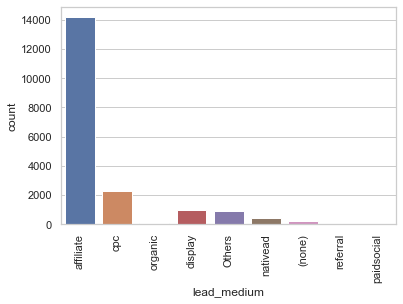

In [201]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a medium with a total of leads < 30 'Others'
data['lead_medium'] = data['lead_medium'].replace(np.nan, 'Others')
data['lead_medium'] = data['lead_medium'].replace(data.loc[data.groupby('lead_medium').lead_medium.transform('count').lt(30),
                               'lead_medium'],'Others')

sns.countplot(data['lead_medium'])
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

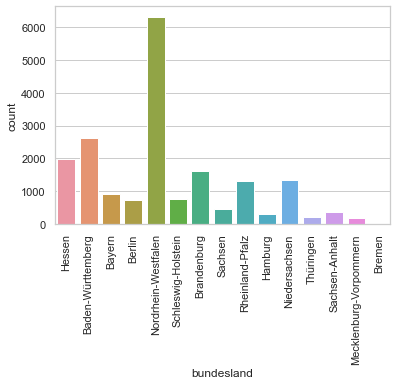

In [202]:
sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [203]:
data.groupby(['bundesland'])['id'].count()

bundesland
Baden-Württemberg         2633
Bayern                     906
Berlin                     724
Brandenburg               1624
Bremen                       6
Hamburg                    303
Hessen                    1967
Mecklenburg-Vorpommern     182
Niedersachsen             1348
Nordrhein-Westfalen       6321
Rheinland-Pfalz           1295
Sachsen                    453
Sachsen-Anhalt             372
Schleswig-Holstein         765
Thüringen                  193
Name: id, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

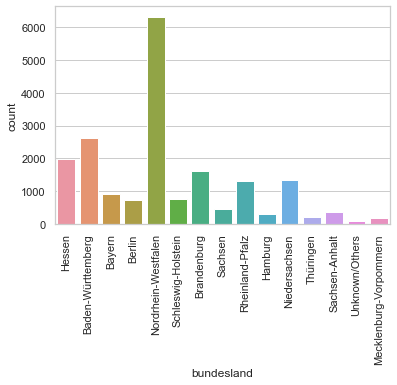

In [204]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a bundesland with a total of leads < 30 'Others'
data['bundesland'] = data['bundesland'].replace(np.nan, 'Unknown/Others')
data['bundesland'] = data['bundesland'].replace(data.loc[data.groupby('bundesland').lead_medium.transform('count').lt(30),
                               'bundesland'],'Unknown/Others')

sns.countplot(data['bundesland'])
xticks(rotation = 90)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 8 Text major ticklabel objects>)

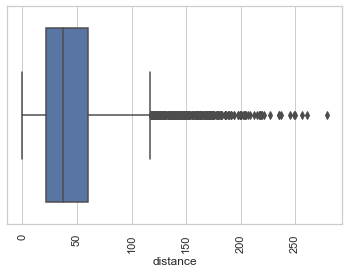

In [205]:
plt1 = sns.boxplot(data['distance'])
xticks(rotation = 90)

<ipython-input-206-1948a3a77387>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance'][data['distance'] <= percentiles[0]] = percentiles[0]
<ipython-input-206-1948a3a77387>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance'][data['distance'] >= percentiles[1]] = percentiles[1]


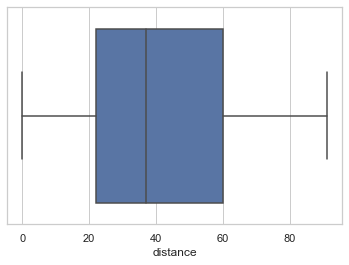

In [206]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
percentiles = data['distance'].quantile([0.00,0.95]).values
data['distance'][data['distance'] <= percentiles[0]] = percentiles[0]
data['distance'][data['distance'] >= percentiles[1]] = percentiles[1]
sns.boxplot(data['distance'])

In [207]:
data['distance'].median()

37.0

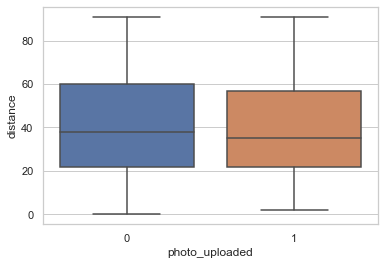

In [208]:
sns.boxplot(y = 'distance', x = 'photo_uploaded', data = data)
#median for converted and non converted leads is almost the same

In [209]:
#we will substitute the missing data with the median 
data['distance'] = data['distance'].replace(np.nan, data['distance'].median())



(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

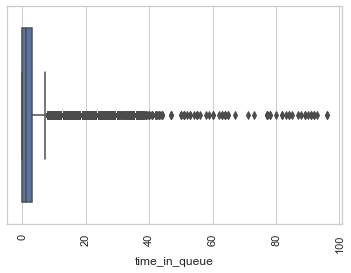

In [210]:
plt1 = sns.boxplot(data['time_in_queue'])
xticks(rotation = 90)

<ipython-input-211-aa16c8108611>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_in_queue'][data['time_in_queue'] <= percentiles[0]] = percentiles[0]


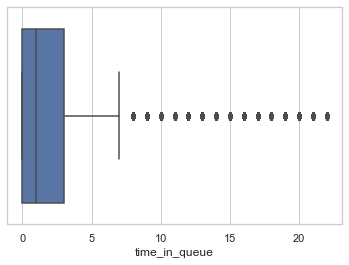

In [211]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
percentiles = data['time_in_queue'].quantile([0.00,0.95]).values
data['time_in_queue'][data['time_in_queue'] <= percentiles[0]] = percentiles[0]
data['time_in_queue'][data['time_in_queue'] >= percentiles[1]] = percentiles[1]
sns.boxplot(data['time_in_queue'])

In [212]:
data['time_in_queue'].median()

1.0

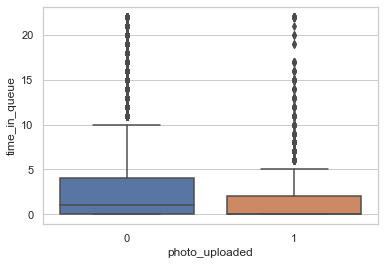

In [213]:
sns.boxplot(y = 'time_in_queue', x = 'photo_uploaded', data = data)
#median for converted and non converted leads is different

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 <a list of 7 Text major ticklabel objects>)

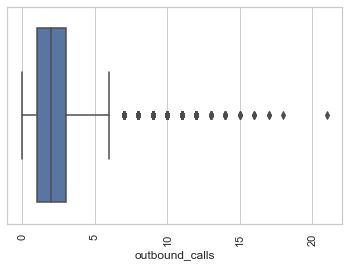

In [214]:
plt1 = sns.boxplot(data['outbound_calls'])
xticks(rotation = 90)

<ipython-input-215-6d81dd6cf5c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outbound_calls'][data['outbound_calls'] <= percentiles[0]] = percentiles[0]


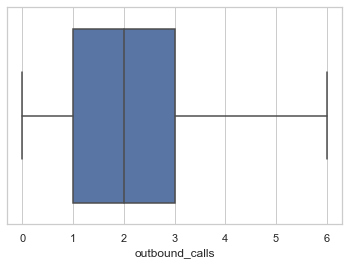

In [215]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
percentiles = data['outbound_calls'].quantile([0.00,0.95]).values
data['outbound_calls'][data['outbound_calls'] <= percentiles[0]] = percentiles[0]
data['outbound_calls'][data['outbound_calls'] >= percentiles[1]] = percentiles[1]
sns.boxplot(data['outbound_calls'])

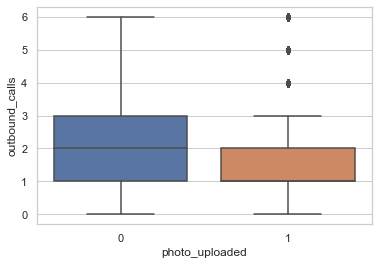

In [216]:
sns.boxplot(y = 'outbound_calls', x = 'photo_uploaded', data = data)
#median for converted and non converted leads is different

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 11 Text major ticklabel objects>)

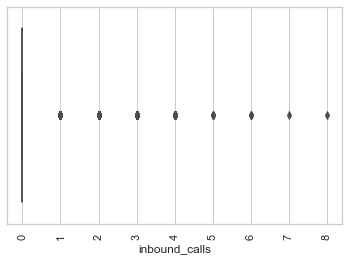

In [217]:
plt1 = sns.boxplot(data['inbound_calls'])
xticks(rotation = 90)

<ipython-input-218-1ecb402a32d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inbound_calls'][data['inbound_calls'] <= percentiles[0]] = percentiles[0]


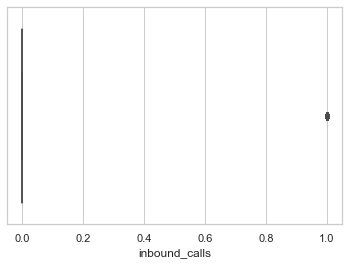

In [218]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
percentiles = data['inbound_calls'].quantile([0.00,0.95]).values
data['inbound_calls'][data['inbound_calls'] <= percentiles[0]] = percentiles[0]
data['inbound_calls'][data['inbound_calls'] >= percentiles[1]] = percentiles[1]
sns.boxplot(data['inbound_calls'])

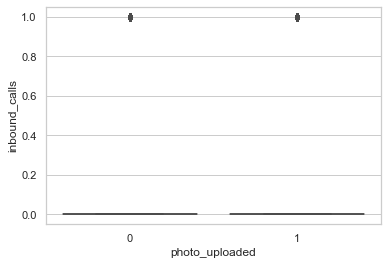

In [219]:
sns.boxplot(y = 'inbound_calls', x = 'photo_uploaded', data = data)
#median for converted and non converted leads is the same so we will not use inbound calls

In [220]:
data=data.drop(['inbound_calls'],1)

In [221]:
data['record_type_name_c'].describe()


count       19171
unique          2
top       Regular
freq        14707
Name: record_type_name_c, dtype: object

In [222]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                           0.0
lead_source                  0.0
lead_medium                  0.0
bundesland                   0.0
distance                     0.0
record_type_name_c           0.0
has_opened                   0.0
has_clicked_non_photo_url    0.0
photo_uploaded               0.0
outbound_calls               0.0
has_been_wfp                 0.0
time_in_queue                0.0
dtype: float64

In [223]:
#Exploratory Data Analytics
# Univariate Analysis 

In [224]:
Converted = (sum(data['photo_uploaded'])/len(data['photo_uploaded'].index))*100
Converted

17.448229096030463

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

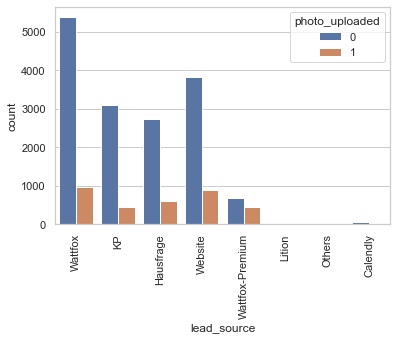

In [225]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

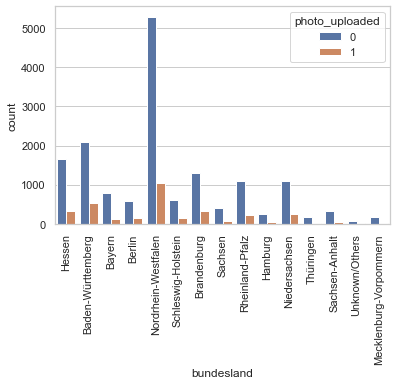

In [226]:
#lead_source 
sns.countplot(x = "bundesland", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

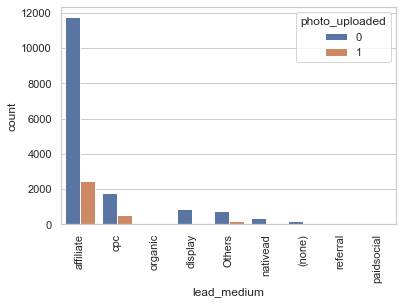

In [227]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

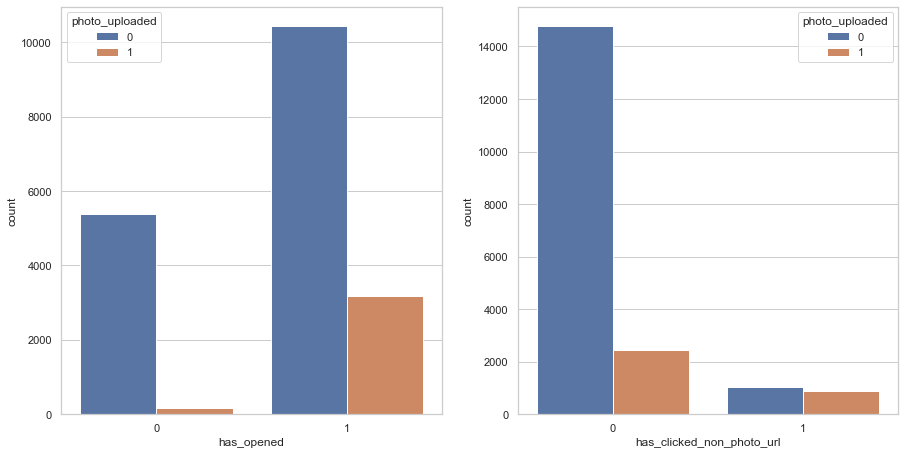

In [228]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_uploaded", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_uploaded", data = data, ax = axs[1])

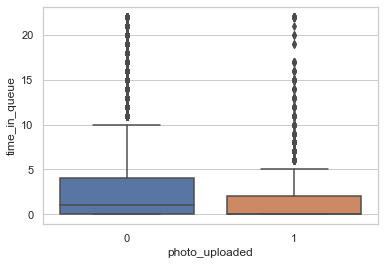

In [229]:
sns.boxplot(y = 'time_in_queue', x = 'photo_uploaded', data = data)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

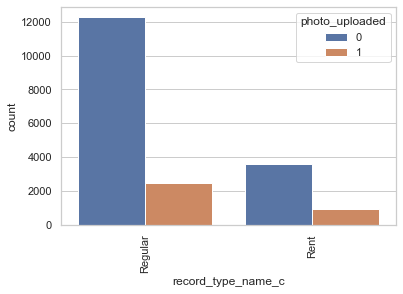

In [230]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

In [231]:
d = data.corr()
m = ((d>0.5)&(d!=1))|((d<-0.5)&(d!=-1))
d[m].stack().drop_duplicates().round(3).to_dict()

{('photo_uploaded', 'has_been_wfp'): 0.619,
 ('outbound_calls', 'time_in_queue'): 0.569}

In [232]:
#because outbound calls and time in queue correlate with each other we take the outbound call out
#see if model is better without bundesland and try to delete wfp
data=data.drop(['outbound_calls','distance','has_been_wfp'],1)

In [233]:
data.head(10)

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue
0,00Q5J000003ZoItUAK,Wattfox,affiliate,Hessen,Regular,1,0,0,0
1,00Q5J000003ZnhxUAC,KP,affiliate,Hessen,Regular,0,0,0,1
2,00Q5J000002rmI0UAI,Hausfrage,affiliate,Baden-Württemberg,Regular,1,1,1,0
3,00Q5J000003aQ0pUAE,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,1,0
4,00Q5J000003ZhnUUAS,Website,cpc,Bayern,Regular,1,0,1,3
5,00Q5J000003Y8CfUAK,Website,organic,Berlin,Regular,1,1,1,5
6,00Q5J000002rzciUAA,Hausfrage,affiliate,Nordrhein-Westfalen,Regular,0,0,0,22
7,00Q5J000003Zk93UAC,Hausfrage,affiliate,Schleswig-Holstein,Regular,0,0,0,0
8,00Q5J000003atC0UAI,KP,affiliate,Brandenburg,Regular,1,0,0,9
9,00Q5J000003YmkCUAS,Hausfrage,affiliate,Nordrhein-Westfalen,Regular,1,0,0,22


In [234]:
# Data Preparation



In [235]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source',# 'radius_category',
                           'lead_medium','bundesland'
                             ]], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [236]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003ZoItUAK,Wattfox,affiliate,Hessen,Regular,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,00Q5J000003ZnhxUAC,KP,affiliate,Hessen,Regular,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00Q5J000002rmI0UAI,Hausfrage,affiliate,Baden-Württemberg,Regular,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003aQ0pUAE,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000003ZhnUUAS,Website,cpc,Bayern,Regular,1,0,1,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [237]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland',#'radius_category',
                             'record_type_name_c'], axis = 1)


In [238]:
data.head(10)

,id,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003ZoItUAK,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,00Q5J000003ZnhxUAC,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00Q5J000002rmI0UAI,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003aQ0pUAE,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000003ZhnUUAS,1,0,1,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,00Q5J000003Y8CfUAK,1,1,1,5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000002rzciUAA,0,0,0,22,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,00Q5J000003Zk93UAC,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,00Q5J000003atC0UAI,1,0,0,9,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,00Q5J000003YmkCUAS,1,0,0,22,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [239]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_uploaded'], axis=1)
X.head()

,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [240]:
y = data['photo_uploaded']

y.head()

0    0
1    0
2    1
3    1
4    1
Name: photo_uploaded, dtype: int64

In [241]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.3, random_state=None)

In [242]:
X_train.head()

,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
543,1,0,22,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7009,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
15353,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9528,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2694,1,1,8,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [243]:
#feature scaling
scaler = StandardScaler()


X_train[['time_in_queue']] = scaler.fit_transform(
    X_train[['time_in_queue']])

#X_train[['distance']] = scaler.fit_transform(
#    X_train[['distance']])

X_train.head()

<ipython-input-243-dfa6a3991bf6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['time_in_queue']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
543,1,0,2.955224,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7009,1,0,-0.416625,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
15353,1,0,-0.416625,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9528,1,0,-0.577189,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2694,1,1,0.707325,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [244]:
#How many conversions do we have 

Converted = (sum(data['photo_uploaded'])/len(data['photo_uploaded'].index))*100
Converted

17.448229096030463

In [245]:
#Model building 

In [246]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         photo_uploaded   No. Observations:                13419
Model:                            GLM   Df Residuals:                    13385
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5065.4
Date:                Fri, 05 Feb 2021   Deviance:                       10131.
Time:                        09:15:21   Pearson chi2:                 1.35e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.1483      0.542     -7.655      0.000      -5.210      -3.086
has_opened                            2.0748      0.100     20.809      0.000       1.879       2.270
has_clicked_non_photo_url             1.4959      0.068     22.157      0.000       1.364       1.628
time_in_queue                        -0.7221      0.044    -16.389      0.000      -0.808      -0.636
record_type_name_c_Rent               0.2217      0.061      3.646      0.000       0.103       0.341
lead_source_Hausfrage                -0.0278      0.611     -0.046      0.964      -1.225       1.169
lead_source_KP                       -0.2132      0.613     -0.348      0.728      -1.414       0.988
lead_source_Lition                   -0.0232      0.846     -0.027      0.978      -1.682       1.636
lead_source_Others                    1.3322      0.690      1.930      0.054      -0.021       2.685
lead_source_Wattfox                  -0.1597      0.610     -0.262      0.794      -1.355       1.036
lead_source_Wattfox-Premium           0.5953      0.615      0.967      0.333      -0.611       1.801
lead_source_Website                   0.5226      0.482      1.085      0.278      -0.421       1.466
lead_medium_Others                    0.4545      0.254      1.786      0.074      -0.044       0.953
lead_medium_affiliate                 0.6146      0.461      1.332      0.183      -0.289       1.519
lead_medium_cpc                       0.2447      0.233      1.049      0.294      -0.213       0.702
lead_medium_display                  -0.7391      0.266     -2.778      0.005      -1.261      -0.218
lead_medium_nativead                 -0.8546      0.314     -2.719      0.007      -1.471      -0.239
lead_medium_organic                   0.8290      0.359      2.312      0.021       0.126       1.532
lead_medium_paidsocial                0.6472      0.580      1.117      0.264      -0.489       1.783
lead_medium_referral                  0.1847      0.686      0.269      0.788      -1.159       1.528
bundesland_Bayern                    -0.2151      0.137     -1.571      0.116      -0.483       0.053
bundesland_Berlin                     0.0334      0.138      0.242      0.809      -0.237       0.304
bundesland_Brandenburg               -0.0289      0.104     -0.279      0.780      -0.232       0.174
bundesland_Hamburg                    0.0151      0.202      0.075      0.940      -0.381       0.412
bundesland_Hessen                    -0.1945      0.102     -1.900      0.057      -0.395       0.006
bundesland_Mecklenburg-Vorpommern    -1.1530      0.396     -2.913      0.004      -1.929      -0.377
bundesland_Niedersachsen             -0.0477      0.114     -0.418      0.676      -0.272       0.176
bundesland_Nordrhein-We

In [247]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 12)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIO

array([ True,  True,  True, False, False, False, False,  True, False,
        True, False, False, False, False,  True,  True,  True,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True,  True])

In [248]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('time_in_queue', True, 1),
 ('record_type_name_c_Rent', False, 3),
 ('lead_source_Hausfrage', False, 16),
 ('lead_source_KP', False, 13),
 ('lead_source_Lition', False, 17),
 ('lead_source_Others', True, 1),
 ('lead_source_Wattfox', False, 14),
 ('lead_source_Wattfox-Premium', True, 1),
 ('lead_source_Website', False, 2),
 ('lead_medium_Others', False, 4),
 ('lead_medium_affiliate', False, 5),
 ('lead_medium_cpc', False, 6),
 ('lead_medium_display', True, 1),
 ('lead_medium_nativead', True, 1),
 ('lead_medium_organic', True, 1),
 ('lead_medium_paidsocial', True, 1),
 ('lead_medium_referral', False, 12),
 ('bundesland_Bayern', False, 9),
 ('bundesland_Berlin', False, 18),
 ('bundesland_Brandenburg', False, 22),
 ('bundesland_Hamburg', False, 19),
 ('bundesland_Hessen', False, 11),
 ('bundesland_Mecklenburg-Vorpommern', True, 1),
 ('bundesland_Niedersachsen', False, 20),
 ('bundesland_Nordrhein-Westfalen', False, 7),
 (

In [249]:
col = X_train.columns[rfe.support_]

# this is me just taking out the ones that are > 0.1
#col =X_train.columns[([ True,  True, True,  True, True, True, 
#                       False,  False,  False, True,  False,  False,
#                       True,  True, True,  False,  True, True,
#                        False,  True, False, True, False, False, 
#                       False,  False, True, False, True,  False,
#                       False, True, False, False,  False])]
col

Index(['has_opened', 'has_clicked_non_photo_url', 'time_in_queue',
       'lead_source_Others', 'lead_source_Wattfox-Premium',
       'lead_medium_display', 'lead_medium_nativead', 'lead_medium_organic',
       'lead_medium_paidsocial', 'bundesland_Mecklenburg-Vorpommern',
       'bundesland_Thüringen', 'bundesland_Unknown/Others'],
      dtype='object')

In [250]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         photo_uploaded   No. Observations:                13419
Model:                            GLM   Df Residuals:                    13406
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5100.3
Date:                Fri, 05 Feb 2021   Deviance:                       10201.
Time:                        09:15:38   Pearson chi2:                 1.35e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.6779      0.097    -38.018      0.000      -3.868      -3.488
has_opened                            2.0639      0.099     20.837      0.000       1.870       2.258
has_clicked_non_photo_url             1.5206      0.067     22.707      0.000       1.389       1.652
time_in_queue                        -0.7525      0.044    -17.183      0.000      -0.838      -0.667
lead_source_Others                    1.2412      0.448      2.770      0.006       0.363       2.119
lead_source_Wattfox-Premium           0.6816      0.086      7.940      0.000       0.513       0.850
lead_medium_display                  -0.6594      0.144     -4.587      0.000      -0.941      -0.378
lead_medium_nativead                 -0.7635      0.220     -3.472      0.001      -1.195      -0.333
lead_medium_organic                   0.7999      0.281      2.845      0.004       0.249       1.351
lead_medium_paidsocial                0.7348      0.531      1.383      0.167      -0.306       1.776
bundesland_Mecklenburg-Vorpommern    -1.0393      0.393     -2.642      0.008      -1.810      -0.268
bundesland_Thüringen                 -0.3770      0.299     -1.262      0.207      -0.963       0.209
bundesland_Unknown/Others             0.4462      0.359      1.241      0.214      -0.258       1.151
=====================================================================================================
"""

In [251]:
#col2 = col.drop(['lead_medium_nativead', 'lead_source_Hausfrage',
#                  'bundesland_Berlin','bundesland_Niedersachsen','bundesland_Rheinland-Pfalz',
#                'bundesland_Sachsen-Anhalt'],1)
#X_train_sm = sm.add_constant(X_train[col2])
#logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
#res = logm2.fit()
#res.summary()

In [252]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

543      0.021085
7009     0.214083
15353    0.214083
9528     0.377993
2694     0.348483
692      0.235114
15480    0.214083
4735     0.037559
13114    0.248053
5457     0.033746
dtype: float64

In [253]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.02108533, 0.21408347, 0.21408347, 0.37799295, 0.34848281,
       0.2351139 , 0.21408347, 0.0375591 , 0.24805257, 0.03374629])

In [254]:
#
y_train_pred_final = pd.DataFrame({'photo_uploaded':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id
0,0,0.021085,543
1,0,0.214083,7009
2,0,0.214083,15353
3,0,0.377993,9528
4,0,0.348483,2694


In [255]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted
0,0,0.021085,543,0
1,0,0.214083,7009,0
2,0,0.214083,15353,0
3,0,0.377993,9528,0
4,0,0.348483,2694,0


In [256]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted )
print(confusion)


[[10814   294]
 [ 1850   461]]


In [257]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted))

0.8402265444518966


In [258]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
0,has_opened,1.28
1,has_clicked_non_photo_url,1.17
4,lead_source_Wattfox-Premium,1.09
5,lead_medium_display,1.04
2,time_in_queue,1.03
3,lead_source_Others,1.02
6,lead_medium_nativead,1.02
11,bundesland_Unknown/Others,1.02
7,lead_medium_organic,1.01
9,bundesland_Mecklenburg-Vorpommern,1.01


In [259]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [260]:
TN

10814

In [261]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.19948074426655127

In [262]:
# Let us calculate specificity
TN / float(TN+FP)

0.973532589124955

In [263]:
# positive predictive value 
print (TP / float(TP+FP))

0.6105960264900663


In [264]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8539166140240051


In [265]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

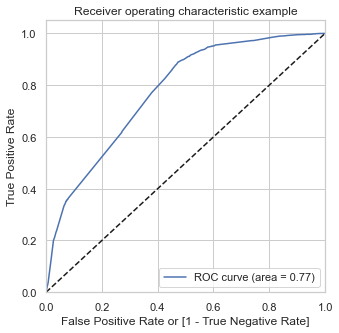

In [266]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_uploaded, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_uploaded, y_train_pred_final.photo_upload_prob)

In [267]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.021085,543,0,1,0,0,0,0,0,0,0,0,0
1,0,0.214083,7009,0,1,1,1,0,0,0,0,0,0,0
2,0,0.214083,15353,0,1,1,1,0,0,0,0,0,0,0
3,0,0.377993,9528,0,1,1,1,1,0,0,0,0,0,0
4,0,0.348483,2694,0,1,1,1,1,0,0,0,0,0,0


In [268]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.172218  1.000000  0.000000
0.1   0.1  0.544899  0.923410  0.466151
0.2   0.2  0.646919  0.771960  0.620904
0.3   0.3  0.827334  0.355690  0.925459
0.4   0.4  0.837842  0.236694  0.962910
0.5   0.5  0.840227  0.199481  0.973533
0.6   0.6  0.828080  0.036348  0.992798
0.7   0.7  0.828080  0.034617  0.993158
0.8   0.8  0.828005  0.001298  1.000000
0.9   0.9  0.827782  0.000000  1.000000


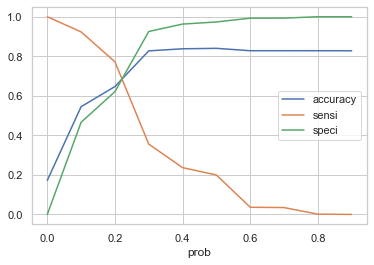

In [269]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [270]:
#### From the curve above, 0.2 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.021085,543,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.214083,7009,0,1,1,1,0,0,0,0,0,0,0,1
2,0,0.214083,15353,0,1,1,1,0,0,0,0,0,0,0,1
3,0,0.377993,9528,0,1,1,1,1,0,0,0,0,0,0,1
4,0,0.348483,2694,0,1,1,1,1,0,0,0,0,0,0,1


In [271]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,0.021085,543,0,1,0,0,0,0,0,0,0,0,0,0,2
1,0,0.214083,7009,0,1,1,1,0,0,0,0,0,0,0,1,21
2,0,0.214083,15353,0,1,1,1,0,0,0,0,0,0,0,1,21
3,0,0.377993,9528,0,1,1,1,1,0,0,0,0,0,0,1,38
4,0,0.348483,2694,0,1,1,1,1,0,0,0,0,0,0,1,35


In [272]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_uploaded, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.771960190393769

In [273]:
# Let us calculate specificity
TN / float(TN+FP)

0.6209038530788621

In [274]:
# Calculate false postive rate - predicting photo when customer did not send photo
print(FP/ float(TN+FP))

0.3790961469211379


In [275]:
# Positive predictive value 
print (TP / float(TP+FP))

0.297581317764804


In [276]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9290140086206896


In [277]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted )
confusion

array([[10814,   294],
       [ 1850,   461]])

In [278]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.6105960264900663

In [279]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.19948074426655127

In [280]:
y_train_pred_final.photo_uploaded, y_train_pred_final.predicted

(0        0
 1        0
 2        0
 3        0
 4        0
         ..
 13414    0
 13415    0
 13416    1
 13417    0
 13418    0
 Name: photo_uploaded, Length: 13419, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 13414    0
 13415    0
 13416    1
 13417    0
 13418    0
 Name: predicted, Length: 13419, dtype: int64)

In [281]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_uploaded, y_train_pred_final.photo_upload_prob)

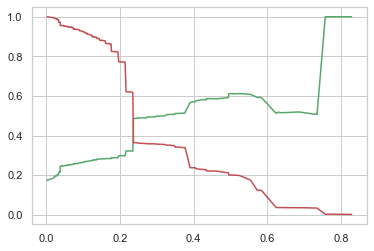

In [282]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [283]:
#Making predictions on the test set

X_test[['time_in_queue']] = scaler.fit_transform(X_test[['time_in_queue']])

X_train.head()

<ipython-input-283-32c7eeaa7025>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['time_in_queue']] = scaler.fit_transform(X_test[['time_in_queue']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
543,1,0,2.955224,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7009,1,0,-0.416625,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
15353,1,0,-0.416625,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9528,1,0,-0.577189,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2694,1,1,0.707325,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [284]:
X_test = X_test[col]
X_test.head()

,has_opened,has_clicked_non_photo_url,time_in_queue,lead_source_Others,lead_source_Wattfox-Premium,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,bundesland_Mecklenburg-Vorpommern,bundesland_Thüringen,bundesland_Unknown/Others
17775,1,0,-0.586560,0,0,0,0,0,0,0,0,0
6976,0,0,-0.586560,0,0,0,0,0,0,0,0,0
4205,1,0,-0.111564,0,0,0,0,0,0,0,0,0
5766,0,0,-0.111564,0,0,0,0,0,0,0,0,0
17471,1,0,2.896739,0,0,0,0,0,0,0,0,0


In [285]:
X_test_sm = sm.add_constant(X_test)

In [286]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


17775    0.236384
6976     0.037815
4205     0.177987
5766     0.026754
17471    0.022013
18834    0.379652
6742     0.022013
2504     0.215556
9877     0.106616
16901    0.037815
dtype: float64

In [287]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
17775,0.236384
6976,0.037815
4205,0.177987
5766,0.026754
17471,0.022013


In [288]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_uploaded,id,0
0,0,17775,0.236384
1,0,6976,0.037815
2,0,4205,0.177987
3,0,5766,0.026754
4,0,17471,0.022013


In [289]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_uploaded,id,photo_upload_prob
0,0,17775,0.236384
1,0,6976,0.037815
2,0,4205,0.177987
3,0,5766,0.026754
4,0,17471,0.022013


In [290]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_uploaded,id,photo_upload_prob,final_predicted
0,0,17775,0.236384,1
1,0,6976,0.037815,0
2,0,4205,0.177987,0
3,0,5766,0.026754,0
4,0,17471,0.022013,0


In [291]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_uploaded, y_pred_final.final_predicted)

0.6557719054242003

In [292]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_uploaded, y_pred_final.final_predicted )
confusion2

array([[2980, 1738],
       [ 242,  792]])

In [293]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [294]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7659574468085106

In [295]:
# Let us calculate specificity
TN / float(TN+FP)

0.6316235693090293

In [296]:
y_pred_final['Lead_Score'] = y_pred_final.photo_upload_prob.map( lambda x: round(x*100))

In [297]:
print(y_pred_final.shape)
y_pred_final.head()

(5752, 5)


,photo_uploaded,id,photo_upload_prob,final_predicted,Lead_Score
0,0,17775,0.236384,1,24
1,0,6976,0.037815,0,4
2,0,4205,0.177987,0,18
3,0,5766,0.026754,0,3
4,0,17471,0.022013,0,2


In [298]:
y_train_pred_final=y_train_pred_final.drop(['predicted',0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],1)
print(y_train_pred_final.shape)
y_train_pred_final.head()

(13419, 5)


,photo_uploaded,photo_upload_prob,id,final_predicted,Lead_Score
0,0,0.021085,543,0,2
1,0,0.214083,7009,1,21
2,0,0.214083,15353,1,21
3,0,0.377993,9528,1,38
4,0,0.348483,2694,1,35


In [299]:
y_pred_final=y_pred_final[['id','photo_uploaded','photo_upload_prob','final_predicted','Lead_Score']]
y_train_pred_final=y_train_pred_final[['id','photo_uploaded','photo_upload_prob','final_predicted','Lead_Score']]

In [300]:
y_pred_final.head()

,id,photo_uploaded,photo_upload_prob,final_predicted,Lead_Score
0,17775,0,0.236384,1,24
1,6976,0,0.037815,0,4
2,4205,0,0.177987,0,18
3,5766,0,0.026754,0,3
4,17471,0,0.022013,0,2


In [301]:
pred_values=pd.concat([y_train_pred_final,y_pred_final]).reset_index(drop=True)
pred_values.shape

(19171, 5)

In [302]:
pred_values.head()

,id,photo_uploaded,photo_upload_prob,final_predicted,Lead_Score
0,543,0,0.021085,0,2
1,7009,0,0.214083,1,21
2,15353,0,0.214083,1,21
3,9528,0,0.377993,1,38
4,2694,0,0.348483,1,35


In [303]:
Final= base.merge(pred_values, how='left',left_index=True,right_on='id', suffixes=('_left', '_right')).reset_index(drop=True)
Final.shape

(19171, 19)

In [304]:
Final.loc[Final.photo_uploaded_left != Final.photo_uploaded_right]

,id,id_left,lead_source,lead_medium,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded_left,outbound_calls,inbound_calls,has_been_wfp,time_in_queue,id_right,photo_uploaded_right,photo_upload_prob,final_predicted,Lead_Score


In [306]:
Final=Final[['id_left','Lead_Score','photo_uploaded_left','lead_source','lead_medium','bundesland',#'radius_category','distance',
             'record_type_name_c','has_opened',	'has_clicked_non_photo_url',
             'time_in_queue']]
Final.head(50)

,id_left,Lead_Score,photo_uploaded_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,time_in_queue
0,00Q5J000003ZoItUAK,24,0,Wattfox,affiliate,Hessen,Regular,1,0,0
1,00Q5J000003ZnhxUAC,3,0,KP,affiliate,Hessen,Regular,0,0,1
2,00Q5J000002rmI0UAI,58,1,Hausfrage,affiliate,Baden-Württemberg,Regular,1,1,0
3,00Q5J000003aQ0pUAE,24,1,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0
4,00Q5J000003ZhnUUAS,18,1,Website,cpc,Bayern,Regular,1,0,3
5,00Q5J000003Y8CfUAK,63,1,Website,organic,Berlin,Regular,1,1,5
6,00Q5J000002rzciUAA,0,0,Hausfrage,affiliate,Nordrhein-Westfalen,Regular,0,0,37
7,00Q5J000003Zk93UAC,4,0,Hausfrage,affiliate,Schleswig-Holstein,Regular,0,0,0
8,00Q5J000003atC0UAI,9,0,KP,affiliate,Brandenburg,Regular,1,0,9
9,00Q5J000003YmkCUAS,2,0,Hausfrage,affiliate,Nordrhein-Westfalen,Regular,1,0,28


In [309]:
#res = logm2.fit()
res

In [311]:
#X_train_sm #= sm.add_constant(X_train[col])
logm2 #= sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
#res = logm2.fit()
#res.summary()

In [312]:
res

In [314]:
import pickle

In [354]:
data = pickle.dumps(res)

In [356]:
#data

In [331]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")

sql = "INSERT INTO eigensonne_dwh.public.fit_model VALUES(%s)"
cr = conn.cursor()
cr.execute(sql, (psycopg2.Binary(data),) )
conn.commit() 


In [332]:
cr.close()

In [357]:
loaded_model = pickle.loads(data)

In [361]:
result = loaded_model.predict(X_test_sm)

In [362]:
result

17775    0.236384
6976     0.037815
4205     0.177987
5766     0.026754
17471    0.022013
           ...   
8686     0.005695
4        0.177987
14069    0.018865
17174    0.061715
11909    0.236384
Length: 5752, dtype: float64

In [363]:
# save file using joblib
from joblib import dump
joblib.dump(res, 'trained_model.pkl') 

['trained_model.pkl']

In [364]:
# Load the model from the file
clf_from_joblib = joblib.load('trained_model.pkl') 

In [366]:
# Use the loaded model to make predictions
clf_from_joblib.predict(X_test_sm)

17775    0.236384
6976     0.037815
4205     0.177987
5766     0.026754
17471    0.022013
           ...   
8686     0.005695
4        0.177987
14069    0.018865
17174    0.061715
11909    0.236384
Length: 5752, dtype: float64

In [350]:
res.params

const                               -3.677903
has_opened                           2.063900
has_clicked_non_photo_url            1.520564
time_in_queue                       -0.752520
lead_source_Others                   1.241184
lead_source_Wattfox-Premium          0.681581
lead_medium_display                 -0.659402
lead_medium_nativead                -0.763546
lead_medium_organic                  0.799916
lead_medium_paidsocial               0.734828
bundesland_Mecklenburg-Vorpommern   -1.039270
bundesland_Thüringen                -0.376966
bundesland_Unknown/Others            0.446176
dtype: float64